In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from pandas_profiling import ProfileReport
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
dataset = pd.read_csv("Dataset.csv")
print(dataset.head())

                                                Text     Category
0  Changing the filter for your home s heating. v...  Health News
1  NASHVILLE. Tenn. (AP) — Tennessee s strict abo...  Health News
2  Work long enough. and you ll eventually face t...  Health News
3  AUSTIN. Texas (AP) — A Texas doctor said Thurs...  Health News
4  INDIANAPOLIS (AP) — An Indianapolis doctor who...  Health News


In [41]:
dataset.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
target_category = dataset['Category'].unique()
print(target_category)

['Health News' 'Politics News' 'Business News' 'Entertainment News']


In [43]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,Text,Category,CategoryId
0,Changing the filter for your home s heating. v...,Health News,0
1,NASHVILLE. Tenn. (AP) — Tennessee s strict abo...,Health News,0
2,Work long enough. and you ll eventually face t...,Health News,0
3,AUSTIN. Texas (AP) — A Texas doctor said Thurs...,Health News,0
4,INDIANAPOLIS (AP) — An Indianapolis doctor who...,Health News,0


In [44]:
# Create a new pandas dataframe "category", which only has unique Categories, also sorting this list in order of CategoryId values
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,Health News,0
211,Politics News,1
592,Business News,2
635,Entertainment News,3


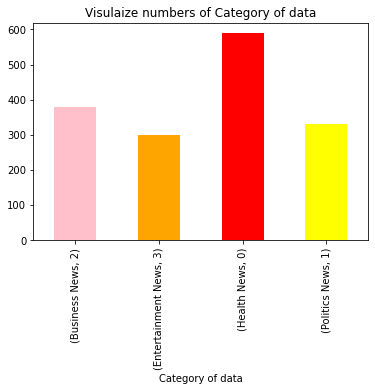

In [45]:
dataset.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

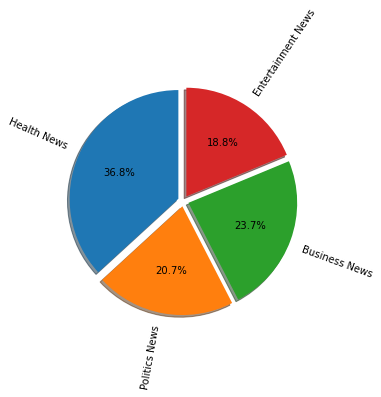

In [46]:
fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
Health = dataset[dataset['CategoryId'] == 0 ]
Politics = dataset[dataset['CategoryId'] == 1 ]
Business = dataset[dataset['CategoryId'] == 2]
Entertainment = dataset[dataset['CategoryId'] == 3]
count = [Health['CategoryId'].count(), Politics['CategoryId'].count(), Business['CategoryId'].count(), Entertainment['CategoryId'].count()]
pie = plt.pie(count, labels = ['Health News', 'Politics News', 'Business News', 'Entertainment News'],
              autopct = "%1.1f%%",
              shadow = True,
              startangle = 90,
              rotatelabels=45,
              explode = (0.05, 0.05, 0.05, 0.05))

Health related words:


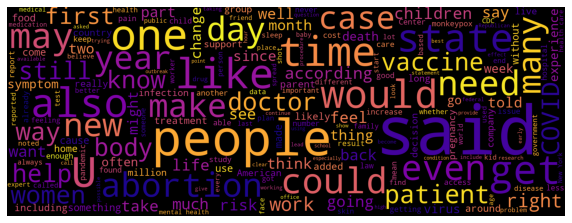

Politics related words:


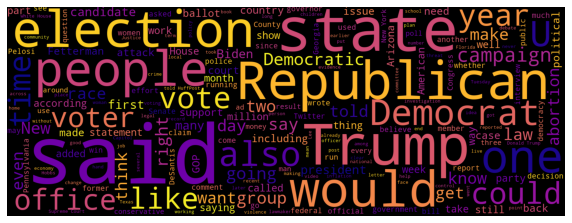

Business related words:


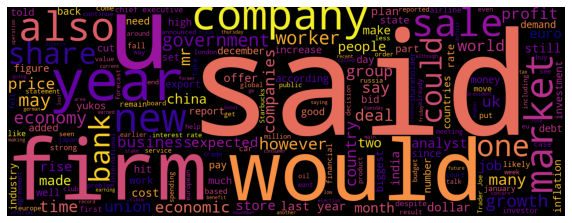

Entertainment related words:


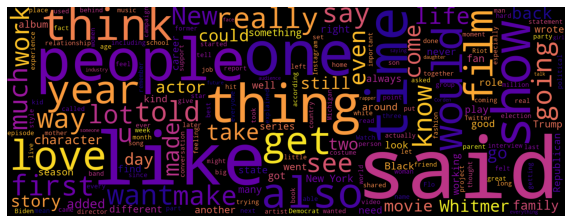

In [47]:
stop = set(stopwords.words('english'))

Health = dataset[dataset['CategoryId'] == 0]

Health = Health['Text']

Politics = dataset[dataset['CategoryId'] == 1]

Politics = Politics['Text']

Business = dataset[dataset['CategoryId'] == 2]

Business = Business['Text']

Entertainment = dataset[dataset['CategoryId'] == 3]

Entertainment = Entertainment['Text']

def wordcloud_draw(dataset, color = 'black'):

    words = ' '.join(dataset)

    cleaned_word = ' '.join([word for word in words.split()

    if (word != 'news' and word != 'text')])

    wordcloud = WordCloud(stopwords = stop,

    background_color = color,
                          
    contour_color='black', colormap='plasma',

    width = 1600, height = 600).generate(cleaned_word)

    plt.figure(1, figsize = (10,7))

    plt.imshow(wordcloud)

    plt.axis("off")

    plt.show()

print("Health related words:")
wordcloud_draw(Health, 'black')

print("Politics related words:")
wordcloud_draw(Politics, 'black')

print("Business related words:")
wordcloud_draw(Business, 'black')

print("Entertainment related words:")
wordcloud_draw(Entertainment, 'black')

In [50]:
text = dataset["Text"]
text.head(10)

0    Changing the filter for your home s heating. v...
1    NASHVILLE. Tenn. (AP) — Tennessee s strict abo...
2    Work long enough. and you ll eventually face t...
3    AUSTIN. Texas (AP) — A Texas doctor said Thurs...
4    INDIANAPOLIS (AP) — An Indianapolis doctor who...
5    Monkeypoxreport presentedThe committee agreed ...
6    toll of opioidsTogether. the developments amou...
7    abortionThe study. which waspublished Tuesday ...
8    There s an old saying that adversity makes you...
9    After the debate between Pennsylvania Senate c...
Name: Text, dtype: object

In [51]:
category = dataset['Category']
category.head(10)

0    Health News
1    Health News
2    Health News
3    Health News
4    Health News
5    Health News
6    Health News
7    Health News
8    Health News
9    Health News
Name: Category, dtype: object

In [52]:
old_df = dataset.copy()
old_df['length_of_news'] = old_df['Text']
old_df['len_news'] = old_df['length_of_news'].map(lambda x: len(x))
old_df.head()

,Text,Category,CategoryId,length_of_news,len_news
0,Changing the filter for your home s heating. v...,Health News,0,Changing the filter for your home s heating. v...,2701
1,NASHVILLE. Tenn. (AP) — Tennessee s strict abo...,Health News,0,NASHVILLE. Tenn. (AP) — Tennessee s strict abo...,2254
2,Work long enough. and you ll eventually face t...,Health News,0,Work long enough. and you ll eventually face t...,1778
3,AUSTIN. Texas (AP) — A Texas doctor said Thurs...,Health News,0,AUSTIN. Texas (AP) — A Texas doctor said Thurs...,2075
4,INDIANAPOLIS (AP) — An Indianapolis doctor who...,Health News,0,INDIANAPOLIS (AP) — An Indianapolis doctor who...,3301


In [53]:
#remove all tag
def remove_tags(text):
  remove = re.compile(r'')
  return re.sub(remove, '', text)
dataset['Text'] = dataset['Text'].apply(remove_tags)

In [54]:
#Remove Special Characters
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews
dataset['Text'] = dataset['Text'].apply(special_char)

In [55]:
#Remove all Stopwords
def convert_lower(text):
   return text.lower()
dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][1]

'nashville  tenn   ap    tennessee s strict abortion ban does not apply to the disposal of fertilized human embryos that haven t been transferred to a uterus  according to a recent state attorney general opinion the determination is among the first issued by an attorney general that provides insight on how laws heavily restricting abortion affect those seeking in vitro fertilization  or ivf  since the u s  supreme court overturned the constitutional right to abortion  disposing of an embryo that was created outside a woman s body and that has never been transferred to a woman s body thus does not qualify as  abortion    jonathan skrmetti wrote in his opinion the two page document was quietly published on the attorney general s website on oct  20 at the request of tennessee s senate majority leader jack johnson  a republican currently seeking reelection tennessee s lawtrigger law while i felt that the law was clear and that it did not apply to this particular case and others like it  i 

In [56]:
#Lemmatizing the Words
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]
dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][1]

['nashville',
 'tenn',
 'ap',
 'tennessee',
 'strict',
 'abortion',
 'ban',
 'apply',
 'disposal',
 'fertilized',
 'human',
 'embryos',
 'transferred',
 'uterus',
 'according',
 'recent',
 'state',
 'attorney',
 'general',
 'opinion',
 'determination',
 'among',
 'first',
 'issued',
 'attorney',
 'general',
 'provides',
 'insight',
 'laws',
 'heavily',
 'restricting',
 'abortion',
 'affect',
 'seeking',
 'vitro',
 'fertilization',
 'ivf',
 'since',
 'u',
 'supreme',
 'court',
 'overturned',
 'constitutional',
 'right',
 'abortion',
 'disposing',
 'embryo',
 'created',
 'outside',
 'woman',
 'body',
 'never',
 'transferred',
 'woman',
 'body',
 'thus',
 'qualify',
 'abortion',
 'jonathan',
 'skrmetti',
 'wrote',
 'opinion',
 'two',
 'page',
 'document',
 'quietly',
 'published',
 'attorney',
 'general',
 'website',
 'oct',
 '20',
 'request',
 'tennessee',
 'senate',
 'majority',
 'leader',
 'jack',
 'johnson',
 'republican',
 'currently',
 'seeking',
 'reelection',
 'tennessee',
 'lawtr

In [57]:
nltk.download('omw-1.4')
def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])
dataset['Text'] = dataset['Text'].apply(lemmatize_word)
dataset['Text'][1]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'nashville tenn ap tennessee strict abortion ban apply disposal fertilized human embryo transferred uterus according recent state attorney general opinion determination among first issued attorney general provides insight law heavily restricting abortion affect seeking vitro fertilization ivf since u supreme court overturned constitutional right abortion disposing embryo created outside woman body never transferred woman body thus qualify abortion jonathan skrmetti wrote opinion two page document quietly published attorney general website oct 20 request tennessee senate majority leader jack johnson republican currently seeking reelection tennessee lawtrigger law felt law clear apply particular case others like happy ask attorney general opinion clear perceived misunderstanding law pleased attorney general arrived conclusion johnson said skrmetti opinion clarifies disposal unused embryo remains unclear law applies selective reduction process sometimes used remove fetus woman womb fertil

In [58]:
x = dataset['Text']
y = dataset['CategoryId']

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset.Text).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1600, 5000)
y.shape =  (1600,)


In [60]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train))
print(len(x_test))

1120
480


In [61]:
final_df = dataset.copy()
final_df['length_of_news'] = final_df['Text']
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,Text,Category,CategoryId,length_of_news,len_news
0,changing filter home heating ventilation air c...,Health News,0,changing filter home heating ventilation air c...,1711
1,nashville tenn ap tennessee strict abortion ba...,Health News,0,nashville tenn ap tennessee strict abortion ba...,1619
2,work long enough eventually face common pressu...,Health News,0,work long enough eventually face common pressu...,1314
3,austin texas ap texas doctor said thursday wor...,Health News,0,austin texas ap texas doctor said thursday wor...,1457
4,indianapolis ap indianapolis doctor performed ...,Health News,0,indianapolis ap indianapolis doctor performed ...,2505


In [62]:
lenmax_df = final_df.groupby('Category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,Category,len_news
1,Entertainment News,27816
2,Health News,24436
3,Politics News,18429
0,Business News,7166


In [63]:
lenmin_df = final_df.groupby('Category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,Category,len_news
3,Politics News,94
1,Entertainment News,84
0,Business News,81
2,Health News,21


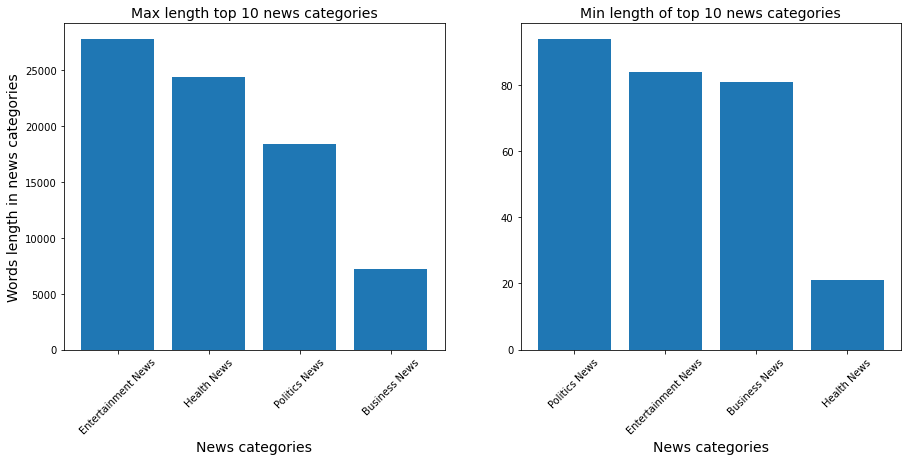

In [64]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['Category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['Category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

In [65]:
old_length = old_df['length_of_news'].apply(len).sum()
new_length = final_df['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 4523395
New chracters length of text data: 3074189


In [67]:
old_text = old_df['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = final_df['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 759362
New word length of text data: 432085


In [68]:
#create list of model and accuracy dicts
perform_list = [ ]

In [69]:
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')
    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'F1-score : {f1score}')
    # Add performance parameters to list
    perform_list.append(dict([
    ('Model', model_name),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
    ]))

In [70]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

C:\Dev\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Dev\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optim

Test Accuracy Score of Basic Logistic Regression: % 80.83
Precision : 0.8083333333333333
Recall : 0.8083333333333333
F1-score : 0.8083333333333333


In [71]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 81.46
Precision : 0.8145833333333333
Recall : 0.8145833333333333
F1-score : 0.8145833333333333


In [72]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 81.88
Precision : 0.81875
Recall : 0.81875
F1-score : 0.81875


In [73]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Support Vector Classifer: % 80.0
Precision : 0.8
Recall : 0.8
F1-score : 0.8000000000000002


In [74]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Decision Tree Classifier: % 67.5
Precision : 0.675
Recall : 0.675
F1-score : 0.675


In [75]:
run_model('K Nearest Neighbour', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic K Nearest Neighbour: % 62.29
Precision : 0.6229166666666667
Recall : 0.6229166666666667
F1-score : 0.6229166666666667


In [76]:
run_model('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Gaussian Naive Bayes: % 68.75
Precision : 0.6875
Recall : 0.6875
F1-score : 0.6875


In [77]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,80.83,0.81,0.81,0.81
1,Random Forest,81.46,0.81,0.81,0.81
2,Multinomial Naive Bayes,81.88,0.82,0.82,0.82
3,Support Vector Classifer,80.00,0.80,0.80,0.80
4,Decision Tree Classifier,67.50,0.68,0.68,0.68
5,K Nearest Neighbour,62.29,0.62,0.62,0.62
6,Gaussian Naive Bayes,68.75,0.69,0.69,0.69


In [78]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
print("The best accuracy of model is", max_value,"from Random")

The best accuracy of model is 81.88 from Random


In [79]:
import joblib
classifier = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0).fit(x_train, y_train)
classifier
joblib.dump(classifier, '4514Model.pkl')
joblib.dump(cv, 'cv.pkl')
y_pred = classifier.predict(x_test)

In [80]:
y_pred1 = cv.transform(['Hour ago, I contemplated retirement for a lot of reasons. I felt like people were not sensitive enough to my injuries. I felt like a lot of people were backed, why not me? I have done no less. I have won a lot of games for the team, and I am not feeling backed, said Ashwin'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
  result = "Health News"
elif yy == [1]:
  result = "Politics News"
elif yy == [2]:
  result = "Business News"
elif yy == [3]:
  result = "Entertainment News"

print(result)

Entertainment News


In [81]:
y_pred1 = cv.transform(['The world behind the on-screen magic is once again thrown into light in Behind Every Star, the Korean remake of the popular French behind-the-stars drama Call My Agent!.'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
  result = "Health News"
elif yy == [1]:
  result = "Politics News"
elif yy == [2]:
  result = "Business News"
elif yy == [3]:
  result = "Entertainment News"

print(result)

Entertainment News


In [82]:
y_pred1 = cv.transform(['In most people, norovirus causes a few days of misery spent in the bathroom and then is quickly forgotten. Epstein-Barr virus can pass without any indication at all. And many people shrug off Covid-19.'])
yy = classifier.predict(y_pred1)
result = ""
if yy == [0]:
  result = "Health News"
elif yy == [1]:
  result = "Politics News"
elif yy == [2]:
  result = "Business News"
elif yy == [3]:
  result = "Entertainment News"

print(result)

Health News
